In [83]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

In [133]:
np.random.seed(42)

X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X.drop(['boat', 'body', 'home.dest'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [85]:
X_train.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
999,3,"McCarthy, Miss. Catherine 'Katie'",female,NaN,0,0,383123,7.7500,NaN,Q
392,2,"del Carlo, Mrs. Sebastiano (Argenia Genovesi)",female,24.0,1,0,SC/PARIS 2167,27.7208,NaN,C
628,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.2750,NaN,S
1165,3,"Saad, Mr. Khalil",male,25.0,0,0,2672,7.2250,NaN,C
604,3,"Abelseth, Miss. Karen Marie",female,16.0,0,0,348125,7.6500,NaN,S


In [86]:
X_train.isnull().any()

pclass      False
name        False
sex         False
age          True
sibsp       False
parch       False
ticket      False
fare         True
cabin        True
embarked    False
dtype: bool

In [87]:
X_train.isnull().sum()

pclass        0
name          0
sex           0
age         209
sibsp         0
parch         0
ticket        0
fare          1
cabin       822
embarked      0
dtype: int64

In [ ]:
! pip install missingno


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


<Figure size 1000x500 with 0 Axes>

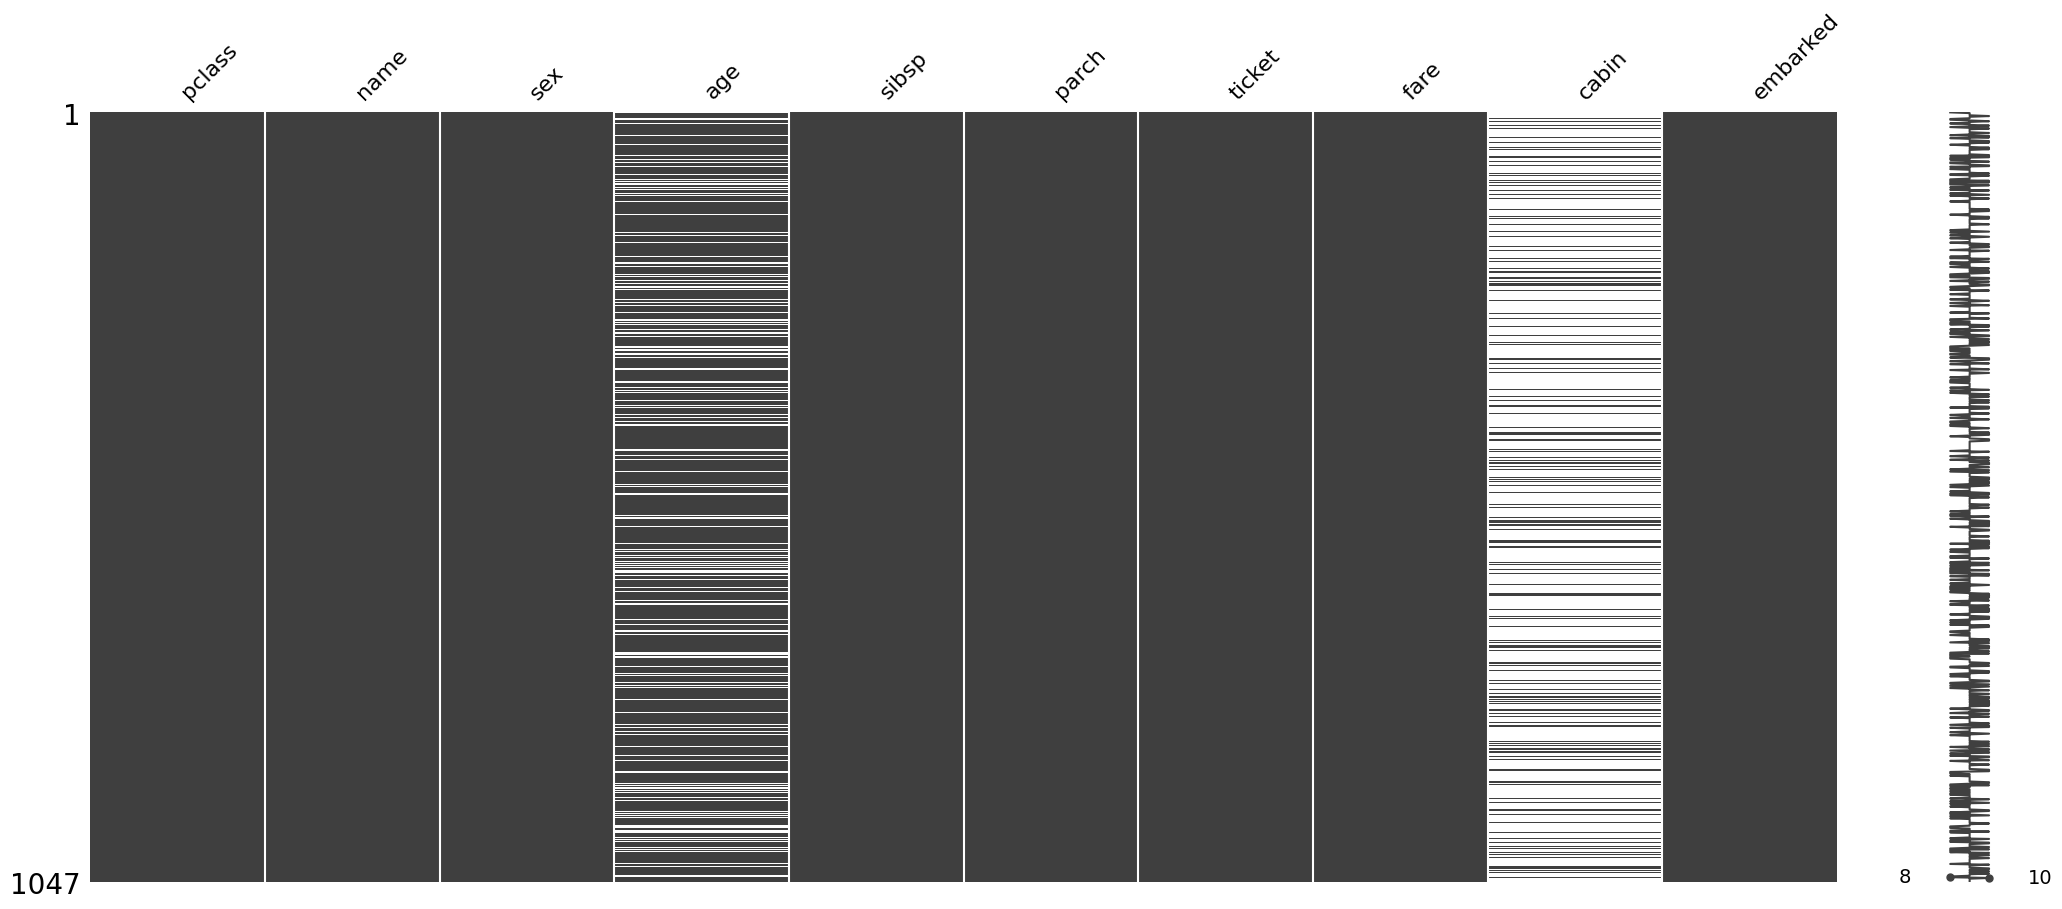

In [89]:
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'png'

plt.figure(figsize=(10, 5))
msno.matrix(X_train)
plt.show()

In [90]:
X_train.isnull().sum() / len(X_train) * 100

pclass       0.000000
name         0.000000
sex          0.000000
age         19.961796
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.095511
cabin       78.510029
embarked     0.000000
dtype: float64

In [91]:
X_train.drop(['cabin'], axis=1, inplace=True)
X_test.drop(['cabin'], axis=1, inplace=True)

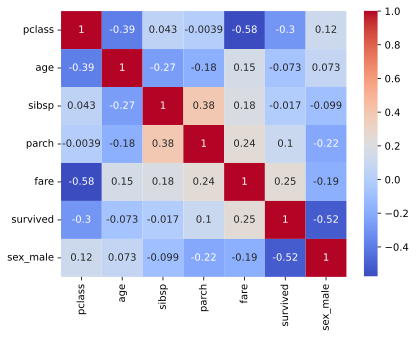

In [92]:
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'svg'

# Convert categorical 'sex' column to dummy variables
X_comb = pd.concat([X_train, y_train.astype(float)], axis=1)
X_comb_encoded = pd.get_dummies(X_comb[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'survived']], drop_first=True)

# Compute the correlation matrix on the encoded data
g = sns.heatmap(X_comb_encoded.corr(), annot=True, cmap="coolwarm")


In [ ]:
for dataset in [X_train, X_test]:
    dataset['family_size'] = dataset['parch'] + dataset['sibsp']
    dataset.drop(['parch', 'sibsp'], axis=1, inplace=True)
    dataset['is_alone'] = 1
    dataset.loc[dataset['family_size'] > 1, 'is_alone'] = 0

X_train.head()

,pclass,name,sex,age,ticket,fare,embarked,family_size,is_alone
999,3,"McCarthy, Miss. Catherine 'Katie'",female,NaN,383123,7.7500,Q,0,1
392,2,"del Carlo, Mrs. Sebastiano (Argenia Genovesi)",female,24.0,SC/PARIS 2167,27.7208,C,1,1
628,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,347082,31.2750,S,6,0
1165,3,"Saad, Mr. Khalil",male,25.0,2672,7.2250,C,0,1
604,3,"Abelseth, Miss. Karen Marie",female,16.0,348125,7.6500,S,0,1


In [94]:
for dataset in [X_train, X_test]:
    dataset['title'] =  dataset['name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    dataset.drop(["name"], axis=1, inplace=True)

X_train.head()

,pclass,sex,age,ticket,fare,embarked,family_size,is_alone,title
999,3,female,NaN,383123,7.7500,Q,0,1,Miss
392,2,female,24.0,SC/PARIS 2167,27.7208,C,1,1,Mrs
628,3,female,11.0,347082,31.2750,S,6,0,Miss
1165,3,male,25.0,2672,7.2250,C,0,1,Mr
604,3,female,16.0,348125,7.6500,S,0,1,Miss


In [95]:
pd.crosstab(X_train['title'], X_train['sex'])

sex,female,male
title,,
Capt,0,1
Col,0,3
Don,0,1
Dona,1,0
Dr,0,6
Major,0,1
Master,0,51
Miss,210,0
Mlle,2,0


In [ ]:
print(f"Miss: {np.sum(y_train.astype(int)[X_train.title == 'Miss']) / len(X_train.title == 'Miss')}")
print(f"Mrs: {np.sum(y_train.astype(int)[X_train.title == 'Mrs']) / len(X_train.title == 'Mrs')}")

Miss: 0.13371537726838587
Mrs: 0.1174785100286533


In [97]:
X_comb = pd.concat([X_train, X_test])
rare_titles = (X_comb['title'].value_counts() < 10)
rare_titles

title
Mr              False
Miss            False
Mrs             False
Master          False
Rev              True
Dr               True
Col              True
Mlle             True
Ms               True
Major            True
Don              True
the Countess     True
Capt             True
Dona             True
Lady             True
Mme              True
Sir              True
Jonkheer         True
Name: count, dtype: bool

In [ ]:
# Correct the chained assignment warning
for dataset in [X_train, X_test]:
    dataset.loc[dataset.title == 'Miss', 'title'] = 'Mrs'

# Fix the KeyError when accessing 'rare_titles'
dataset['title'] = dataset.title.apply(lambda x: 'rare' if rare_titles.get(x, False) else x)

In [101]:
for dataset in [X_train, X_test]:
    dataset.drop('ticket', axis=1, inplace=True)

X_train.head()

,pclass,sex,age,fare,embarked,family_size,is_alone,title
999,3,female,NaN,7.7500,Q,0,1,Mrs
392,2,female,24.0,27.7208,C,1,1,Mrs
628,3,female,11.0,31.2750,S,6,0,Mrs
1165,3,male,25.0,7.2250,C,0,1,Mr
604,3,female,16.0,7.6500,S,0,1,Mrs


In [102]:
X_train.dtypes

pclass            int64
sex            category
age             float64
fare            float64
embarked       category
family_size       int64
is_alone          int64
title            object
dtype: object

In [103]:
def get_cat_cols(df):
    obj_cols = df.columns[df.dtypes == 'object']
    cat_cols = df.columns[df.dtypes == 'category']
    return set(obj_cols).union(set(cat_cols))

cat_cols = get_cat_cols(X_train)
cat_cols

{'embarked', 'sex', 'title'}

In [109]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('pca', PCA(n_components=10))
])

In [110]:
cat_transformer[0]

SimpleImputer(strategy='most_frequent')

In [116]:
from sklearn.impute import SimpleImputer
import numpy as np

# Corrected SimpleImputer without 'verbose' argument
simple_imputer = SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=np.nan, strategy='most_frequent')


In [117]:
num_cols = ['age', 'fare', 'family_size']
num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

In [118]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

In [119]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy").mean()

np.float64(0.7650079744816589)

In [130]:
num_transformer_dist = {'preprocessor__num__imputer__n_neighbors': list(range(2, 15)),
                        'preprocessor__num__imputer__add_indicator': [True, False]}

cat_transformer_dist = {'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
                        'preprocessor__cat__imputer__add_indicator': [True, False],
                        'preprocessor__cat__pca__n_components': list(range(2, 15))}

random_forest_dist = {'classifier__n_estimators': list(range(50, 500)),
                      'classifier__max_depth': list(range(2, 20)),
                      'classifier__bootstrap': [True, False]}

param_dist = {**num_transformer_dist, **cat_transformer_dist, **random_forest_dist}

random_search = RandomizedSearchCV(clf,
                                   param_distributions=param_dist,
                                   n_iter=100)


In [131]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['age',
                                                                                'fare',
                                                                                'family_size']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False)),
                                                                                               ('pca'...
                                                                     74, 75, 76,
                                                                     77, 78, 79, ...],
                                        'preprocessor__cat__imputer__add_indicator': [True,
                                                                                      False],
                                        'preprocessor__cat__imputer__strategy': ['most_frequent',
                                                                                 'constant'],
                                        'preprocessor__cat__pca__n_components': [2,
                                                                                 3,
                                                                                 4,
                                                                                 5,
                                                                                 6,
                                                                                 7,
                                                                                 8,
                                                                                 9,
                                                                                 10,
                                                                                 11,
                                                                                 12,
                                                                                 13,
                                                                                 14],
                                        'preprocessor__num__imputer__add_indicator': [True,
                                                                                      False],
                                        'preprocessor__num__imputer__n_neighbors': [2,
                                                                                    3,
                                                                                    4,
                                                                                    5,
                                                                                    6,
                                                                  

In [122]:
random_search.best_score_

np.float64(0.8022738664843929)

In [123]:
random_search.best_params_

{'preprocessor__num__imputer__n_neighbors': 13,
 'preprocessor__num__imputer__add_indicator': False,
 'preprocessor__cat__pca__n_components': 7,
 'preprocessor__cat__imputer__strategy': 'constant',
 'preprocessor__cat__imputer__add_indicator': False,
 'classifier__n_estimators': 324,
 'classifier__max_depth': 2,
 'classifier__bootstrap': True}

Model Evaluation

In [ ]:
y_pred = random_search.predict(X_test)
y_pred[:5]

array(['0', '1', '0', '0', '0'], dtype=object)

In [125]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       162
           1       0.83      0.67      0.74       100

    accuracy                           0.82       262
   macro avg       0.82      0.79      0.80       262
weighted avg       0.82      0.82      0.82       262



In [126]:
sum(y_pred == y_test) / len(y_pred)


0.8206106870229007

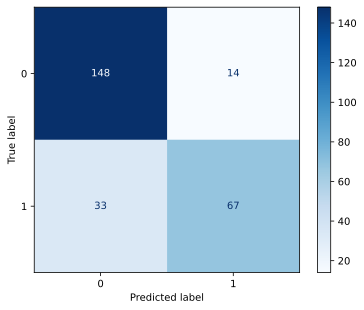

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
y_pred = random_search.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_search.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()